# Data exploration of experimental events
* https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
## Data import

In [1]:
# Imports
import matplotlib.pyplot as plt
from master_scripts.data_functions import *
from pprint import pprint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%load_ext autoreload
%autoreload 2


In [2]:
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events
REPO_ROOT = get_git_root()
DATA_PATH = REPO_ROOT + "/data/real/anodedata_500k.txt"
DATA_FILENAME = "anodedata_500k.txt"

events, images = import_real_data(DATA_PATH) # images not normalized

In [3]:
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events
# ================== Import Data ==================
#images = np.load(DATA_PATH + "images_full.npy")
#positions = np.load(DATA_PATH + "positions_full.npy")
#energies = np.load(DATA_PATH + "energies_full.npy")
#labels = np.load(DATA_PATH + "labels_full.npy")
images_sim = np.load(REPO_ROOT + "data/simulated/images_260k.npy")
positions_sim = np.load(REPO_ROOT + "data/simulated/positions_260k.npy")
energies_sim = np.load(REPO_ROOT + "data/simulated/energies_260k.npy")
labels_sim = np.load(REPO_ROOT + "data/simulated/labels_260k.npy")
single_sim, double_sim, close_sim = event_indices(positions_sim)
print(f"S: {single_sim.shape}, D: {double_sim.shape}, C: {close_sim.shape}")

S: (130279,), D: (129868,), C: (1809,)


In [4]:
THESIS_PATH = "../../../master_thesis/"

# Basic statistical properties
Means, standard deviations etc.

## Images
num_observations, (min, max), mean, variance, skewness, kurtosis

In [5]:
decays = [e['image_idx'] for e in events.values() if e['event_descriptor'] == 2]

In [6]:
stats_images = stats.describe(images[decays])
stats_images_sim = stats.describe(images_sim)

In [7]:
# Print maximum and minimum pixel values seen in image data
print("{:15s}|{:^15s}|{:^15s}|{:^15s}|{:^15s}".format(
    "Image set",
    "pixel min",
    "pixel max",
    "pixel mean",
    "pixel STD (mean)"))
print("{:15s}|{:^15.2f}|{:^15.2f}|{:^15.2f}|{:^15.2f}".format(
    "Exp", 
    np.amin(stats_images.minmax[0]),
    np.amax(stats_images.minmax[1]),
    np.mean(stats_images.mean),
    np.mean(np.sqrt(stats_images.variance))))
print("{:15s}|{:^15.2f}|{:^15.2f}|{:^15.2f}|{:^15.2f}".format(
    "Sim", 
    np.amin(stats_images_sim.minmax[0]),
    np.amax(stats_images_sim.minmax[1]),
    np.mean(stats_images_sim.mean),
    np.mean(np.sqrt(stats_images_sim.variance))))

Image set      |   pixel min   |   pixel max   |  pixel mean   |pixel STD (mean)
Exp            |     0.00      |    8530.83    |    226.38     |    337.86     
Sim            |     0.00      |   11835.00    |    157.58     |    429.79     


## Highest intensity pixel heatmap
Extract the positions of highest intensity pixels across the dataset and plot the
resulting heatmap

## Where do "dead" pixels occur
Extract the positions of "dead" pixels across the dataset and plot the
resulting heatmap, annotated with ratio of images where the pixel is zero

# Distribution comparisons between sim and exp
Though we lack true values for energies, positions, and labels for experimental data, 

In [8]:
images = normalize_image_data(images[decays])
images_sim = normalize_image_data(images_sim)

In [9]:
img_sum = np.sum(images, axis=(1,2))
img_hip = np.amax(images, axis=(1,2))
img_sum_sim = np.sum(images_sim, axis=(1,2))
img_hip_sim = np.amax(images_sim, axis=(1,2))

/home/geir/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


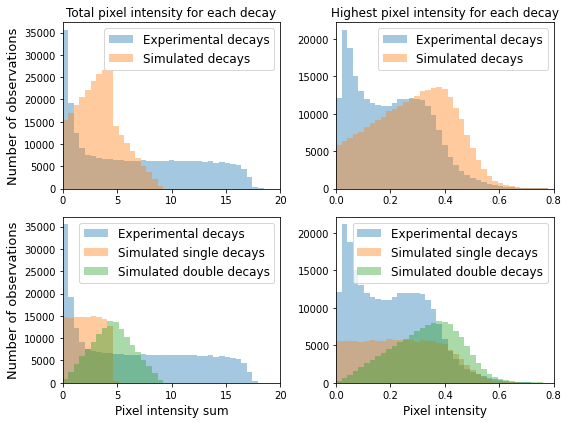

In [10]:

fig, ax = plt.subplots(2, 2, figsize=(8,6))
bins = np.linspace(0, 20, 40)
bins2 = np.linspace(0, 0.8, 40)

# Sum all
sns.distplot(img_sum, kde=False, label='Experimental decays', bins=bins, ax=ax.flatten()[0])
sns.distplot(img_sum_sim, kde=False, label='Simulated decays', bins=bins, ax=ax.flatten()[0])
ax.flatten()[0].set_ylabel("Number of observations", fontsize=13)
ax.flatten()[0].set_title("Total pixel intensity for each decay")
ax.flatten()[0].set_xlim(0, 20)
ax.flatten()[0].legend(fontsize=12)

# HIP all
sns.distplot(img_hip, kde=False, label='Experimental decays', bins=bins2, ax=ax.flatten()[1])
sns.distplot(img_hip_sim, kde=False, label='Simulated decays', bins=bins2, ax=ax.flatten()[1])
ax.flatten()[1].set_title("Highest pixel intensity for each decay")
ax.flatten()[1].set_xlim(0, 0.8)
ax.flatten()[1].legend(fontsize=12)
fig.tight_layout()


#fig1, ax1 = plt.subplots(1, 2, figsize=(8,5), sharey=True)
# Sum single/double
sns.distplot(img_sum, kde=False, label='Experimental decays', bins=bins, ax=ax.flatten()[2])
sns.distplot(img_sum_sim[single_sim], kde=False, label='Simulated single decays', bins=bins, ax=ax.flatten()[2])
sns.distplot(img_sum_sim[double_sim], kde=False, label='Simulated double decays', bins=bins, ax=ax.flatten()[2])
ax.flatten()[2].set_ylabel("Number of observations", fontsize=13)
ax.flatten()[2].set_xlabel("Pixel intensity sum", fontsize=12)
ax.flatten()[2].set_xlim(0, 20)
ax.flatten()[2].legend(fontsize=12)


# HIP single/double
sns.distplot(img_hip, kde=False, label='Experimental decays', bins=bins2, ax=ax.flatten()[3])
sns.distplot(img_hip_sim[single_sim], kde=False, label='Simulated single decays', bins=bins2, ax=ax.flatten()[3])
sns.distplot(img_hip_sim[double_sim], kde=False, label='Simulated double decays', bins=bins2, ax=ax.flatten()[3])
ax.flatten()[3].set_xlabel("Pixel intensity", fontsize=12)
ax.flatten()[3].set_xlim(0, 0.8)
ax.flatten()[3].legend(fontsize=12)

fig.tight_layout()
section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "comparison_intensity.pdf"
fig.savefig(fname)

In [11]:
img_hip = img_hip.reshape(img_hip.shape[0])
img_sum = img_sum.reshape(img_sum.shape[0])

img_hip_sim = img_hip_sim.reshape(img_hip_sim.shape[0])
img_sum_sim = img_sum_sim.reshape(img_sum_sim.shape[0])

Sim: 11.693386007924477x + -0.5177085664237217
Exp: 36.049322173939224x + -0.5177085664237217


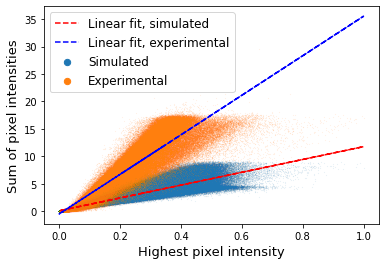

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
a_sim, b_sim = np.polyfit(img_hip_sim, img_sum_sim, 1)
a_exp, b_exp = np.polyfit(img_hip, img_sum, 1)

ax.scatter(img_hip_sim, img_sum_sim, label='Simulated', s=0.001,)
ax.plot(img_hip_sim, a_sim*img_hip_sim + b_sim, '--r', label='Linear fit, simulated')
ax.scatter(img_hip, img_sum, label='Experimental', s=0.001)
ax.plot(img_hip, a_exp*img_hip + b_exp, '--b', label='Linear fit, experimental')
ax.set_xlabel("Highest pixel intensity", fontsize=13)
ax.set_ylabel("Sum of pixel intensities", fontsize=13)
#ax.set_title("Highest pixel intensity in image vs. sum of pixel intensities")
ax.legend(markerscale=200, loc='upper left', fontsize=12)

print(f"Sim: {a_sim}x + {b_exp}")
print(f"Exp: {a_exp}x + {b_exp}")
fig.savefig(THESIS_PATH + section_path + "intensity_hip_comparison.pdf")

In [13]:
custom_ex_id = "05b90ffdfc3c"
custom_model = tf.keras.models.load_model(REPO_ROOT + "models/" + custom_ex_id + ".h5", compile=False)
#custom_test = classification_metrics(custom_model, images, events, "custom_test")
predictions = custom_model.predict(images)
#del custom_model

## Test with scaled single events
Can partially explain problems with double predictions on experimental?

In [14]:
a_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0]
predicted_singles = []
for a in a_factors:
    pred = custom_model.predict((images_sim[single_sim]*a).reshape(single_sim.shape[0], 16, 16, 1))
    pred_s = np.sum((pred <= 0.5).astype(int))
    predicted_singles.append(pred_s/single_sim.shape[0])

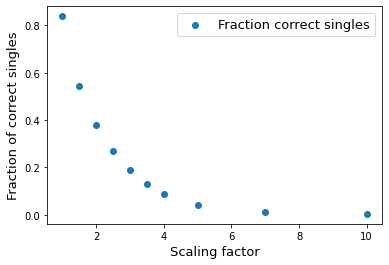

In [15]:
plt.scatter(a_factors, predicted_singles, label="Fraction correct singles")
plt.xlabel("Scaling factor", fontsize=13)
plt.ylabel("Fraction of correct singles", fontsize=13)
plt.legend(fontsize=13)
plt.savefig(THESIS_PATH + section_path + "simulated_scaled_intensity.pdf")

In [139]:
experiments_nomod = {
    'logistic': "1bc7c249cd14",
    'dense': "301dfb138506",
    'cnn': "7f2dd7f1d24c",
    'pretrained': "94685622cb2d",
    'custom': "e8772df34916",
}
experiments_pixelmod = {
    'logistic': "292d34a807ea",
    'dense': "48203947802a",
    'cnn': "35afebe71164",
    'pretrained': "6aebbcd131d1",
    'custom': "05b90ffdfc3c",
}
experiments_imbalanced = {
    'logistic': "9380b00c72f5",
    'dense': "851d3c6f60c8",
    'cnn': "d34250436c72",
    'pretrained': "dd1df8beb788",
    'custom': "28fd163fc0c1",
}

a_factors = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0]
predicted_singles_nomod = {}
predicted_singles_pixelmod = {}
predicted_singles_imbalanced = {}

In [149]:
for model_type, ex_id in experiments_nomod.items():
    predicted_singles_nomod[model_type] = []
    if model_type in ['logistic', 'dense']:
        tmp_img = images_sim[single_sim].reshape(single_sim.shape[0], 256)
    elif model_type == 'pretrained':
        tmp_img = np.concatenate((images_sim[single_sim], images_sim[single_sim], images_sim[single_sim]), axis=-1)
    else:
        tmp_img = images_sim[single_sim]
    model = tf.keras.models.load_model(REPO_ROOT + "models/" + ex_id + ".h5", compile=False)
    for a in a_factors:
        pred = model.predict(tmp_img*a)
        pred_s = np.sum((pred <= 0.5).astype(int))
        predicted_singles_nomod[model_type].append(pred_s/single_sim.shape[0])

In [150]:

for model_type, ex_id in experiments_pixelmod.items():
    predicted_singles_pixelmod[model_type] = []
    if model_type in ['logistic', 'dense']:
        tmp_img = images_sim[single_sim].reshape(single_sim.shape[0], 256)
    elif model_type == 'pretrained':
        tmp_img = np.concatenate((images_sim[single_sim], images_sim[single_sim], images_sim[single_sim]), axis=-1)
    else:
        tmp_img = images_sim[single_sim]
    model = tf.keras.models.load_model(REPO_ROOT + "models/" + ex_id + ".h5", compile=False)
    for a in a_factors:
        pred = model.predict(tmp_img*a)
        pred_s = np.sum((pred <= 0.5).astype(int))
        predicted_singles_pixelmod[model_type].append(pred_s/single_sim.shape[0])

KeyboardInterrupt: 

In [ ]:
for model_type, ex_id in experiments_imbalanced.items():
    predicted_singles_imbalanced[model_type] = []
    if model_type in ['logistic', 'dense']:
        tmp_img = images_sim[single_sim].reshape(single_sim.shape[0], 256)
    elif model_type == 'pretrained':
        tmp_img = np.concatenate((images_sim[single_sim], images_sim[single_sim], images_sim[single_sim]), axis=-1)
    else:
        tmp_img = images_sim[single_sim]
    model = tf.keras.models.load_model(REPO_ROOT + "models/" + ex_id + ".h5", compile=False)
    for a in a_factors:
        pred = model.predict(tmp_img*a)
        pred_s = np.sum((pred <= 0.5).astype(int))
        predicted_singles_imbalanced[model_type].append(pred_s/single_sim.shape[0])

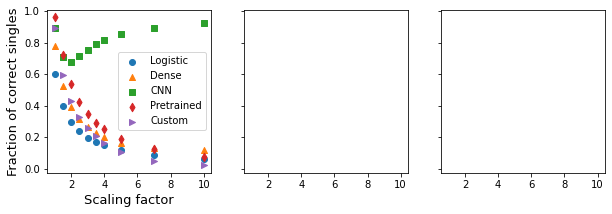

In [155]:
plot_legend = {
    'logistic': "Logistic",
    'dense': "Dense",
    'cnn': "CNN",
    'pretrained': "Pretrained",
    'custom': "Custom",
}
plot_marker = {
    'logistic': 'o',
    'dense': "^",
    'cnn': "s",
    'pretrained': "d",
    'custom': ">",
}
test_dict = {
    'logistic': [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.2, 0.2, 0.1],
    'dense': [0.8, 0.7, 0.7, 0.7, 0.4, 0.3, 0.2, 0.2, 0.2, 0.1],
    'cnn': [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.2, 0.2, 0.1],
    'pretrained': [0.8, 0.7, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1],
    'custom': [0.8, 0.7, 0.6, 0.5, 0.1, 0.2, 0.1, 0.0, 0.0, 0.0],
}
fig, ax = plt.subplots(1,3,figsize=(10, 3), sharex=True, sharey=True)
for k, v in predicted_singles_nomod.items():
    ax[0].scatter(a_factors, v, label=plot_legend[k], marker=plot_marker[k])
    ax[0].set_xlabel("Scaling factor", fontsize=13)
    ax[0].set_ylabel("Fraction of correct singles", fontsize=13)
    ax[0].legend()
    
#fig.savefig(THESIS_PATH + section_path + "simulated_scaled_intensity.pdf")

## Position, regression comparison

In [16]:
# Load position_df
df_pos = pd.read_hdf("../results/experimental_pos_500k.h5", "df", "r")

In [17]:
# === Get location of highest intensity pixels in the images
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get indices of max values along the columns.

max_idx = images.reshape(images.shape[0],-1).argmax(1)
max_idx_sim = images_sim.reshape(images_sim.shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images.shape))
maxpos_vect_sim = np.column_stack(np.unravel_index(max_idx_sim, images_sim.shape))

In [18]:
cols = df_pos.columns
dists = {}
for i in range(0, len(cols), 2):
    pos1 = df_pos.iloc[decays][cols[i]]*16
    pos2 = df_pos.iloc[decays][cols[i+1]]*16
    dist = np.sqrt((maxpos_vect[:, 1] - pos1)**2 + (maxpos_vect[:, 2] - pos2)**2)
    dists[cols[i][:-4] + "dist"] = dist
df_dist = pd.DataFrame(data=dists)*3

# simulated distances
dist_sim = np.sqrt((maxpos_vect_sim[single_sim, 1] - positions_sim[single_sim, 0])**2
                  +(maxpos_vect_sim[single_sim, 2] - positions_sim[single_sim, 1])**2)*3

In [19]:
# Get minimum mean distance model and value
min_col = df_dist.describe().loc["mean"].idxmin()
min_mean = df_dist[min_col].mean()
min_mean_sim = np.mean(dist_sim)

/home/geir/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


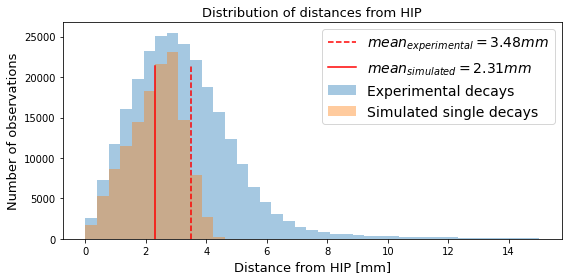

In [20]:
bins = np.linspace(0, 15, 40)
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df_dist['custom_test_pos_pmod_dist'], kde=False, bins=bins, label="Experimental decays", ax=ax)
sns.distplot(dist_sim, kde=False, bins=bins, label="Simulated single decays", ax=ax)
ax.set_xlabel("Distance from HIP [mm]", fontsize=13)
ax.set_ylabel("Number of observations", fontsize=13)
ax.set_title("Distribution of distances from HIP", fontsize=13)
ax.axvline(min_mean, ymax=0.8, c='r', ls='--', label=r"$mean_{{experimental}} = {:.2f}mm$".format(min_mean))
ax.axvline(min_mean_sim, ymax=0.8, c='r', ls='-', label=r"$mean_{{simulated}} = {:.2f}mm$".format(min_mean_sim))
ax.legend(fontsize=14)
fig.tight_layout()
fig.savefig(THESIS_PATH + section_path + 'experimental_pos_dist.pdf')

# Simulated data confusion matrices

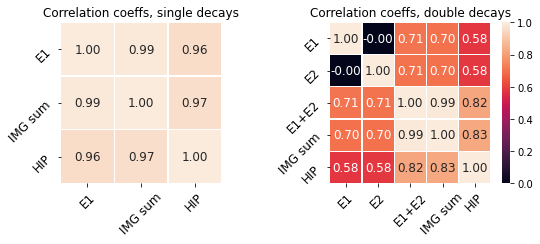

In [132]:
from matplotlib import gridspec
# Concatenate the quantities of interest and draw a reasonable sample size
# from the data to perform calculation on. When the data is huge, this is
# a necessity because np.corrcoef doesn't scale well.
e_sum = np.sum(energies_sim, axis=1).reshape(energies_sim.shape[0],1)
#correlation_data = np.concatenate((positions, energies, sep_dist, rel_e, img_sum, img_hip), axis=1)
correlation_data_double = np.concatenate(
    (
        energies_sim[double_sim, 0].reshape(double_sim.shape[0], 1),
        energies_sim[double_sim, 1].reshape(double_sim.shape[0], 1),
        e_sum[double_sim].reshape(double_sim.shape[0], 1),
        img_sum_sim[double_sim].reshape(double_sim.shape[0], 1),
        img_hip_sim[double_sim].reshape(double_sim.shape[0], 1)
    ),
    axis=1
)
correlation_data_single = np.concatenate(
    (
        energies_sim[single_sim,0].reshape(single_sim.shape[0], 1),
        img_sum_sim[single_sim].reshape(single_sim.shape[0], 1),
        img_hip_sim[single_sim].reshape(single_sim.shape[0], 1)
    ),
    axis=1
)
#indices = np.random.choice(double_sim, 4000, replace=False)

# Calculate correlation matrix
corr_matrix_double = np.corrcoef(correlation_data_double, rowvar=False)
corr_matrix_single = np.corrcoef(correlation_data_single, rowvar=False)

# Plot the correlation matrix
grid_kw = {
    'left': 0.0,
    'right': 1.0,
    'top': 0.66,
    'bottom': 0.0,
}
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))#, gridspec_kw=grid_kw)

#ax1 = plt.subplot2grid((8,16), (0, 0), aspect="auto", colspan=7, rowspan=8, adjustable='box')
#ax2 = plt.subplot2grid((8,16), (0, 0), aspect="auto", colspan=7, rowspan=8, adjustable='box')

#ticks = ["X1", "Y1", "X2", "Y2", "E1", "E2", "sep_dist", "rel_E", "px_sum", "hip"]
ticks_single = ["E1", "IMG sum", "HIP"]
sns.heatmap(
    corr_matrix_single,
    annot=True,
    fmt='.2f',
    linewidth=0.2,
    cbar=False,
    square=True,
    ax=ax[0],
    vmin=0,
    vmax=1,
    annot_kws={'size': 12}
)

ax[0].set_title("Correlation coeffs, single decays")
ax[0].set_xticklabels(ticks_single, rotation=45, fontsize=12)
ax[0].set_yticklabels(ticks_single, rotation=45, fontsize=12)

ticks_double = ["E1", "E2", "E1+E2", "IMG sum", "HIP"]
sns.heatmap(
    corr_matrix_double,
    annot=True,
    fmt='.2f',
    linewidth=0.2,
    square=True,
    ax=ax[1],
    vmin=0,
    vmax=1,
    annot_kws={'size': 12}
)
ax[1].set_title("Correlation coeffs, double decays")
ax[1].set_xticklabels(ticks_double, rotation=45, fontsize=12)
ax[1].set_yticklabels(ticks_double, rotation=45, fontsize=12)
fig.tight_layout()
fig.savefig(THESIS_PATH + section_path + 'simulated_corrcoeff.pdf')
